In [1]:
from google.colab import drive
import os
import zipfile
from shutil import move, copyfile, copy, copy2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
os.chdir('/content/gdrive/My Drive/dogBreedClassifier')
os.getcwd()

'/content/gdrive/My Drive/dogBreedClassifier'

#Preprocessing

Unzipping data

In [5]:
!ls "dataset"

test  train  val


In [ ]:
!unzip dataset/train.zip -d dataset/

In [28]:
list = os.listdir('dataset/train')
number_files = len(list)
number_files

10162

In [ ]:
!unzip dataset/test.zip -d dataset/

In [6]:
list_test = os.listdir('dataset/test')
number_files_test = len(list_test)
number_files_test

10357

Checking the data


In [6]:
df = pd.read_csv('labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
classes = df.breed.unique()
classes.shape, classes

((120,),
 array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
        'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
        'shetland_sheepdog', 'walker_hound', 'maltese_dog',
        'norfolk_terrier', 'african_hunting_dog',
        'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
        'doberman', 'otterhound', 'standard_schnauzer',
        'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
        'affenpinscher', 'labrador_retriever', 'ibizan_hound',
        'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
        'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
        'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
        'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
        'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
        'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
        'miniature_schnauzer', 'brittany_spaniel', 'kelpie', '

In [9]:
df.breed.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

Arranging the data

In [31]:
#creating folders with breeds in train
def class_dirs_create(path, arr):
    try:
        os.mkdir(path)
    except:
        print(path, 'dir already exist')
    try:
        for i in arr:
            os.mkdir(os.path.join(path, i))
    except:
        print('dir already created or path:', path)


#train folders
class_dirs_create('dataset/train', classes)
#val folders
class_dirs_create('dataset/val', classes)

dataset/train dir already exist
dir already created or path error: dataset/train


In [32]:
df_train, df_val = train_test_split(df, test_size=0.3)
df.shape, df_train.shape, df_val.shape

((10222, 2), (7155, 2), (3067, 2))

In [ ]:
#move breeds' data to the folders
for i in df_train.iloc:
    fname = i['id']+'.jpg'
    cur_path = 'dataset/train/'+fname
    new_path = 'dataset/train/'+i['breed'] +'/'+ fname
    try:
        move(cur_path, new_path)
    except:
        print(cur_path,'->', new_path)

In [ ]:
#preparing val
for i in df_val.iloc: # val!
    fname = i['id']+'.jpg'
    cur_path = 'dataset/train/'+fname
    new_path = 'dataset/val/'+i['breed'] +'/'+ fname
    try:
        move(cur_path, new_path)
    except:
        print(cur_path,'->', new_path)

#Training

Transforming data to have more resourses for studying 

In [8]:
#add transforms (as basic augmentations)
transforms_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ColorJitter(), #change brightness, contrast
    transforms.RandomAffine(degrees = 20), #random affine transforms
    transforms.RandomHorizontalFlip(p=0.8), 
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ColorJitter(), #change brightness, contrast
    transforms.RandomAffine(degrees = 20), #random affine transforms
    transforms.RandomHorizontalFlip(p=0.3), 
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder("dataset/train", transforms_train)
val_set = datasets.ImageFolder("dataset/val", transforms_val)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, 
                                          shuffle=True, num_workers=2)

In [9]:
classes = train_set.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
classes

Working at model

In [11]:
#choose model from pretrained torch
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requiers_grad = False
print(model.fc)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Linear(in_features=2048, out_features=1000, bias=True)


In [13]:
model.fc = nn.Linear(2048, len(classes)) # last layer nfeatures -> n classes
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
#checking the model
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
#train
from tqdm import tqdm
for epoch in tqdm(range(100)):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()  
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() 

        running_loss += loss.item()
    print(epoch, running_loss)
print('Finished Training')

  1%|          | 1/100 [12:48<21:08:33, 768.83s/it]

0 482.10580706596375


  2%|▏         | 2/100 [14:02<15:15:04, 560.25s/it]

1 335.298011302948


  3%|▎         | 3/100 [15:15<11:09:24, 414.07s/it]

2 222.51790237426758


  4%|▍         | 4/100 [16:28<8:18:47, 311.74s/it] 

3 162.74126011133194


  5%|▌         | 5/100 [17:41<6:20:03, 240.04s/it]

4 129.3935883641243


  6%|▌         | 6/100 [18:53<4:57:28, 189.88s/it]

5 109.63082575798035


  7%|▋         | 7/100 [20:06<3:59:46, 154.69s/it]

6 96.159796833992


  8%|▊         | 8/100 [21:19<3:19:30, 130.11s/it]

7 84.99228084087372


  9%|▉         | 9/100 [22:32<2:51:13, 112.90s/it]

8 76.20799398422241


 10%|█         | 10/100 [23:44<2:31:17, 100.87s/it]

9 69.6378847360611


 11%|█         | 11/100 [24:57<2:17:04, 92.41s/it] 

10 63.28835025429726


 12%|█▏        | 12/100 [26:10<2:06:47, 86.45s/it]

11 57.752298444509506


 13%|█▎        | 13/100 [27:22<1:59:26, 82.37s/it]

12 52.902286887168884


 14%|█▍        | 14/100 [28:35<1:53:55, 79.48s/it]

13 48.25839129090309


 15%|█▌        | 15/100 [29:48<1:49:50, 77.53s/it]

14 44.783321380615234


 16%|█▌        | 16/100 [31:01<1:46:43, 76.23s/it]

15 41.9883616566658


 17%|█▋        | 17/100 [32:14<1:44:03, 75.23s/it]

16 38.78516627848148


 18%|█▊        | 18/100 [33:27<1:41:43, 74.43s/it]

17 36.408549800515175


 19%|█▉        | 19/100 [34:39<1:39:43, 73.87s/it]

18 33.10900770127773


 20%|██        | 20/100 [35:52<1:38:00, 73.51s/it]

19 31.32377827167511


 21%|██        | 21/100 [37:05<1:36:26, 73.25s/it]

20 29.703291296958923


 22%|██▏       | 22/100 [38:17<1:34:57, 73.05s/it]

21 27.202647648751736


 23%|██▎       | 23/100 [39:30<1:33:35, 72.92s/it]

22 24.58948592096567


 24%|██▍       | 24/100 [40:43<1:32:20, 72.91s/it]

23 22.79469358921051


 25%|██▌       | 25/100 [41:55<1:31:04, 72.86s/it]

24 21.892555825412273


 26%|██▌       | 26/100 [43:08<1:29:48, 72.82s/it]

25 21.203464314341545


 27%|██▋       | 27/100 [44:21<1:28:38, 72.85s/it]

26 18.763745866715908


 28%|██▊       | 28/100 [45:34<1:27:19, 72.77s/it]

27 18.45038726180792


 29%|██▉       | 29/100 [46:46<1:26:06, 72.77s/it]

28 16.782893046736717


 30%|███       | 30/100 [47:59<1:24:53, 72.76s/it]

29 14.979490667581558


 31%|███       | 31/100 [49:12<1:23:42, 72.80s/it]

30 14.843988955020905


 32%|███▏      | 32/100 [50:25<1:22:31, 72.82s/it]

31 13.545558422803879


 33%|███▎      | 33/100 [51:38<1:21:17, 72.80s/it]

32 13.143495447933674


 34%|███▍      | 34/100 [52:50<1:20:02, 72.76s/it]

33 12.526739623397589


 35%|███▌      | 35/100 [54:03<1:18:49, 72.76s/it]

34 11.576536938548088


 36%|███▌      | 36/100 [55:16<1:17:35, 72.75s/it]

35 11.106264781206846


 37%|███▋      | 37/100 [56:28<1:16:20, 72.70s/it]

36 10.093664966523647


 38%|███▊      | 38/100 [57:41<1:15:04, 72.66s/it]

37 9.676446981728077


 39%|███▉      | 39/100 [58:54<1:13:55, 72.71s/it]

38 9.603994842618704


 40%|████      | 40/100 [1:00:06<1:12:41, 72.69s/it]

39 9.155679818242788


 41%|████      | 41/100 [1:01:19<1:11:26, 72.65s/it]

40 8.568475358188152


 42%|████▏     | 42/100 [1:02:32<1:10:15, 72.68s/it]

41 8.29784900136292


 43%|████▎     | 43/100 [1:03:44<1:08:59, 72.63s/it]

42 7.689832702279091


 44%|████▍     | 44/100 [1:04:57<1:07:45, 72.61s/it]

43 7.8543026223778725


 45%|████▌     | 45/100 [1:06:10<1:06:35, 72.64s/it]

44 7.0264747235924006


 46%|████▌     | 46/100 [1:07:22<1:05:21, 72.62s/it]

45 7.139092275872827


 47%|████▋     | 47/100 [1:08:35<1:04:09, 72.63s/it]

46 6.811162516474724


 48%|████▊     | 48/100 [1:09:47<1:02:57, 72.65s/it]

47 6.481567747890949


 49%|████▉     | 49/100 [1:11:00<1:01:46, 72.67s/it]

48 5.995070409029722


 50%|█████     | 50/100 [1:12:13<1:00:34, 72.70s/it]

49 5.698213346302509


 51%|█████     | 51/100 [1:13:26<59:20, 72.66s/it]  

50 5.486440185457468


 52%|█████▏    | 52/100 [1:14:38<58:07, 72.67s/it]

51 5.365666374564171


 53%|█████▎    | 53/100 [1:15:51<56:53, 72.63s/it]

52 5.191468890756369


 54%|█████▍    | 54/100 [1:17:03<55:40, 72.62s/it]

53 5.098424453288317


 55%|█████▌    | 55/100 [1:18:16<54:24, 72.55s/it]

54 4.852129296399653


 56%|█████▌    | 56/100 [1:19:28<53:12, 72.56s/it]

55 4.704929631203413


 57%|█████▋    | 57/100 [1:20:41<51:59, 72.54s/it]

56 4.562415361404419


 58%|█████▊    | 58/100 [1:21:53<50:47, 72.56s/it]

57 4.547573603689671


 59%|█████▉    | 59/100 [1:23:06<49:34, 72.55s/it]

58 4.193285073153675


 60%|██████    | 60/100 [1:24:19<48:22, 72.56s/it]

59 3.98781961761415


 61%|██████    | 61/100 [1:25:31<47:10, 72.57s/it]

60 3.780480054207146


 62%|██████▏   | 62/100 [1:26:44<45:56, 72.54s/it]

61 3.602870191447437


 63%|██████▎   | 63/100 [1:27:56<44:43, 72.53s/it]

62 3.5363234747201204


 64%|██████▍   | 64/100 [1:29:09<43:32, 72.58s/it]

63 3.3701890744268894


 65%|██████▌   | 65/100 [1:30:21<42:19, 72.55s/it]

64 3.7569310162216425


 66%|██████▌   | 66/100 [1:31:34<41:07, 72.57s/it]

65 3.263857294805348


 67%|██████▋   | 67/100 [1:32:47<39:56, 72.61s/it]

66 3.340085447765887


 68%|██████▊   | 68/100 [1:33:59<38:43, 72.60s/it]

67 3.3844478391110897


 69%|██████▉   | 69/100 [1:35:12<37:30, 72.61s/it]

68 3.131409998051822


 70%|███████   | 70/100 [1:36:25<36:19, 72.66s/it]

69 3.000395031645894


 71%|███████   | 71/100 [1:37:37<35:07, 72.68s/it]

70 2.976807126775384


 72%|███████▏  | 72/100 [1:38:50<33:54, 72.67s/it]

71 2.7863754257559776


 73%|███████▎  | 73/100 [1:40:03<32:42, 72.68s/it]

72 2.823528368026018


 74%|███████▍  | 74/100 [1:41:15<31:30, 72.71s/it]

73 2.96636863052845


 75%|███████▌  | 75/100 [1:42:28<30:17, 72.72s/it]

74 3.015554018318653


 76%|███████▌  | 76/100 [1:43:41<29:04, 72.69s/it]

75 2.9533863570541143


 77%|███████▋  | 77/100 [1:44:53<27:51, 72.69s/it]

76 2.7295013274997473


 78%|███████▊  | 78/100 [1:46:06<26:38, 72.67s/it]

77 2.55560673866421


 79%|███████▉  | 79/100 [1:47:19<25:25, 72.63s/it]

78 2.496256347745657


 80%|████████  | 80/100 [1:48:31<24:12, 72.63s/it]

79 2.7463517878204584


 81%|████████  | 81/100 [1:49:44<23:00, 72.66s/it]

80 2.4314441420137882


 82%|████████▏ | 82/100 [1:50:57<21:47, 72.65s/it]

81 2.3576119877398014


 83%|████████▎ | 83/100 [1:52:09<20:35, 72.66s/it]

82 2.46147536393255


 84%|████████▍ | 84/100 [1:53:22<19:22, 72.67s/it]

83 2.347398016601801


 85%|████████▌ | 85/100 [1:54:35<18:09, 72.63s/it]

84 2.332003221847117


 86%|████████▌ | 86/100 [1:55:47<16:57, 72.65s/it]

85 2.293616777751595


 87%|████████▋ | 87/100 [1:57:00<15:44, 72.66s/it]

86 2.193497449159622


 88%|████████▊ | 88/100 [1:58:13<14:32, 72.70s/it]

87 2.15043086046353


 89%|████████▉ | 89/100 [1:59:26<13:20, 72.73s/it]

88 2.106464282143861


 90%|█████████ | 90/100 [2:00:38<12:07, 72.70s/it]

89 2.043298118747771


 91%|█████████ | 91/100 [2:01:51<10:54, 72.70s/it]

90 2.0254335962235928


 92%|█████████▏| 92/100 [2:03:03<09:41, 72.67s/it]

91 1.9987930334173143


 93%|█████████▎| 93/100 [2:04:16<08:28, 72.65s/it]

92 1.9885989646427333


 94%|█████████▍| 94/100 [2:05:29<07:15, 72.64s/it]

93 1.9268858535215259


 95%|█████████▌| 95/100 [2:06:41<06:02, 72.58s/it]

94 2.033909400459379


 96%|█████████▌| 96/100 [2:07:54<04:50, 72.55s/it]

95 1.7147005638107657


 97%|█████████▋| 97/100 [2:09:06<03:37, 72.62s/it]

96 1.9318774659186602


 98%|█████████▊| 98/100 [2:10:19<02:25, 72.62s/it]

97 1.7148081297054887


 99%|█████████▉| 99/100 [2:11:32<01:12, 72.66s/it]

98 1.803348375018686


100%|██████████| 100/100 [2:12:44<00:00, 79.65s/it]

99 1.854695474728942
Finished Training


In [ ]:
class_correct = [0. for i in range(len(classes))]
class_total = [0. for i in range(len(classes))]

with torch.no_grad():
    for i, data in enumerate(val_loader, 0):
        #try:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            print(len(c))
        #except:
            print('first block', labels.shape)
            try: 
                for j in range(labels.shape[0]):
                    label = labels[j]
                    class_correct[label] += c[j].item()
                    class_total[label] += 1
            except:
              print("what")

In [ ]:
for i in range(len(classes)):
    try:
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / (class_total[i])))
    except:
      print(classes[i], class_correct[i])

In [19]:
torch.save(model.state_dict(), 'model_weights100ep.pth')

#Inference

In [5]:
model = models.resnet50()
for param in model.parameters():
  param.requiers_grad = False
model.fc = nn.Linear(2048, 120)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
classes = ['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
               'american_staffordshire_terrier', 'appenzeller', 'australian_terrier',
               'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog',
               'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick',
               'border_collie', 'border_terrier', 'borzoi', 'boston_bull',
               'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard',
               'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever',
               'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie',
               'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
               'doberman', 'english_foxhound', 'english_setter', 'english_springer',
               'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog',
               'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer',
               'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog',
               'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'irish_water_spaniel',
               'irish_wolfhound', 'italian_greyhound', 'japanese_spaniel', 'keeshond',
               'kelpie', 'kerry_blue_terrier', 'komondor', 'kuvasz', 'labrador_retriever',
               'lakeland_terrier', 'leonberg', 'lhasa', 'malamute',
               'malinois', 'maltese_dog', 'mexican_hairless', 'miniature_pinscher',
               'miniature_poodle', 'miniature_schnauzer', 'newfoundland', 'norfolk_terrier', 'norwegian_elkhound',
               'norwich_terrier', 'old_english_sheepdog', 'otterhound', 'papillon',
               'pekinese', 'pembroke', 'pomeranian', 'pug', 'redbone',
               'rhodesian_ridgeback', 'rottweiler', 'saint_bernard', 'saluki', 'samoyed',
               'schipperke', 'scotch_terrier', 'scottish_deerhound', 'sealyham_terrier',
               'shetland_sheepdog', 'shih-tzu', 'siberian_husky', 'silky_terrier',
               'soft-coated_wheaten_terrier', 'staffordshire_bullterrier', 'standard_poodle', 'standard_schnauzer',
               'sussex_spaniel', 'tibetan_mastiff', 'tibetan_terrier', 'toy_poodle',
               'toy_terrier', 'vizsla', 'walker_hound', 'weimaraner', 'welsh_springer_spaniel',
               'west_highland_white_terrier', 'whippet', 'wire-haired_fox_terrier', 'yorkshire_terrier']


In [13]:
transforms_test = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ])
model.eval()

def predict_image(path, model):
    img = Image.open(path).convert('RGB')
    imshow(np.asarray(img))
    image_tensor = transforms_test(img).float()
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(device)
    output = model(image_tensor)
    index = output.argmax().item()
    return classes[index]

Loading the weights

In [20]:
path_weights = '/content/gdrive/My Drive/dogBreedClassifier/model_weights100ep.pth'
model.load_state_dict(torch.load(path_weights))
if torch.cuda.is_available():
    model.cuda()

'golden_retriever'

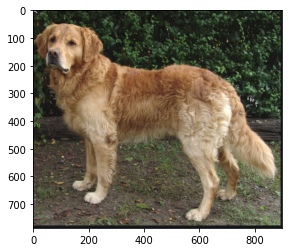

In [21]:
path = '/content/gdrive/My Drive/dogBreedClassifier/444.png'
predict_image(path, model)